# Dreambooth Stable Diffusion

source: https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

In your local environment start a Juypeter Lab server by calling
note: change the project name to yours


In [ ]:
clearml-session --project "ClearML Tutorial" --queue "<=12GB" --user-folder ./ --docker nvidia/cuda:11.6.0-cudnn8-runtime-ubuntu20.04 --vscode-server false --jupyter-lab true

#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

## Install Requirements

In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
!pip install -qq git+https://github.com/ShivamShrirao/diffusers
!pip install -q -U --pre triton
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 natsort safetensors torchvision
!pip install -q xformers==0.0.17.dev447
!pip install -q matplotlib

You should consider upgrading via the '/root/.clearml/venvs-builds/3.8/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/.clearml/venvs-builds/3.8/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/.clearml/venvs-builds/3.8/bin/python -m pip install --upgrade pip' command.


In [12]:
!apt install -qq -y nvidia-cuda-toolkit

nvidia-cuda-toolkit is already the newest version (10.1.243-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [11]:
!ls /usr/local/cuda/lib64/libcudart.so*

/usr/local/cuda/lib64/libcudart.so
/usr/local/cuda/lib64/libcudart.so.11.0
/usr/local/cuda/lib64/libcudart.so.11.6.55


In [10]:
!cp /usr/local/cuda/lib64/libcudart.so.11.0 /usr/local/cuda/lib64/libcudart.so

## Settings and run

In [1]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = "" #@param {type:"string"}
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

In [2]:
#@markdown Object name used in the prompt, e.g., "a photo of [object_name] person".
OBJECT_NAME = "bfn"

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/" + OBJECT_NAME #@param {type:"string"}
OUTPUT_DIR = "content/" + OUTPUT_DIR


import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"[*] Weights will be saved at {OUTPUT_DIR}")

[*] Weights will be saved at content/stable_diffusion_weights/bfn


## Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [3]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
#    {
#        "instance_prompt":      "photo of zwx dog",
#        "class_prompt":         "photo of a dog",
#        "instance_data_dir":    "./content/data/zwx",
#       "class_data_dir":       "./content/data/dog"
#    },
     {
         "instance_prompt":      f"photo of {OBJECT_NAME} bear",
         "class_prompt":         "photo of a bear",
         "instance_data_dir":    f"content/data/{OBJECT_NAME}",
         "class_data_dir":       "content/data/bear"
     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    print(c["instance_data_dir"])
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

content/data/bfn


In [4]:
#@markdown Enter the directory name of your input images (to train the model).
INPUT_IMAGES_DIR = "bear" #@param {type:"string"}

In [5]:
#@markdown Make sure you already put your images in the input image folder you chose
import os

import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")

    #filenames = [os.path.join("pikachu", f) for f in os.listdir("pikachu") if f[-3:] == "jpg"]

    for filename in os.listdir(INPUT_IMAGES_DIR):
        print(filename)
        filename_full = os.path.join(INPUT_IMAGES_DIR, filename)
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.copy(filename_full, dst_path)

Uploading instance images for `photo of bfn bear`
bear4.jpg
bear10.jpg
bear9.jpg
bear6.jpg
bear11.jpg
bear3.jpg
bear1.jpg
bear2.jpg
bear7.jpg
bear8.jpg
bear5.jpg


In [6]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --use_8bit_adam \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of bfn bear" \
  --concepts_list="concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/root/.clearml/venvs-builds/3.8/lib/python3.8/site-packages/accelerate/accelerator.py:231: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
/root/.clearml/venvs-builds/3.8/lib/python3.8/site-packages/accelerate/accelerator.py:336: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")

===================================BUG REPORT===================================
Welcome t

In [7]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=content/stable_diffusion_weights/bfn/800


800


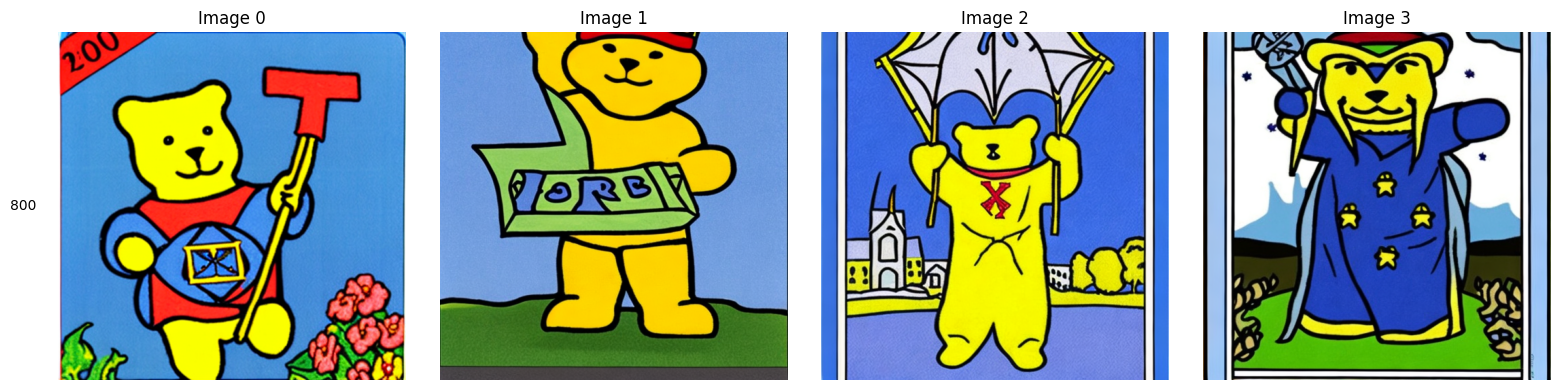

In [8]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
print(folders[0])
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [33]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at content/stable_diffusion_weights/bfn/800/model.ckpt


## Inference

In [12]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

/root/.clearml/venvs-builds/3.8/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [18]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

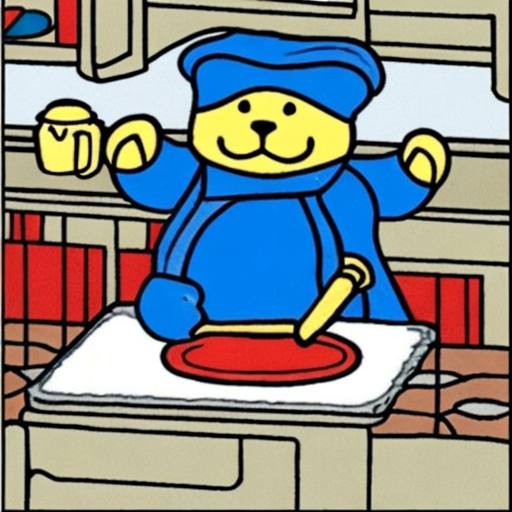

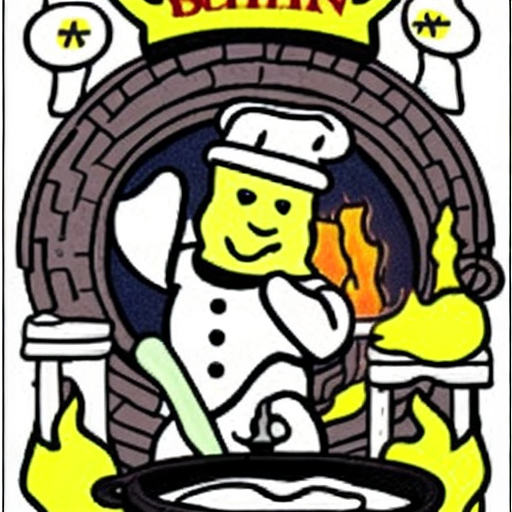

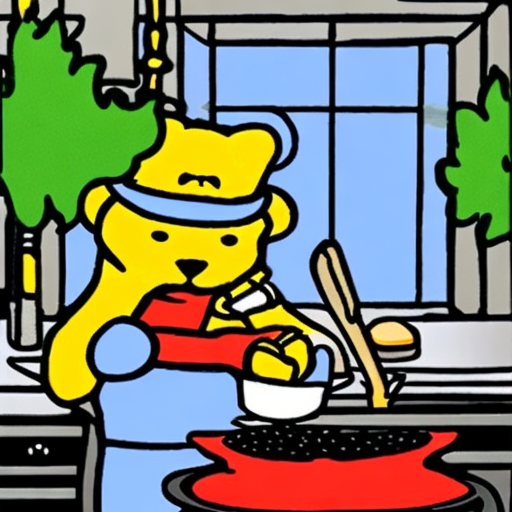

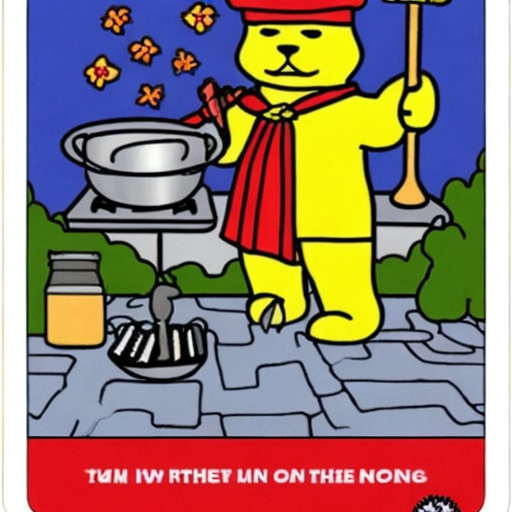

In [20]:
#@title Run for generating images.

prompt = f"photo of {OBJECT_NAME} bear cooking" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

## Free up drive space (Caution!)

In [18]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

Deleted /content/stable_diffusion_weights/zwx/800/vae
Deleted /content/stable_diffusion_weights/zwx/800/samples
Deleted /content/stable_diffusion_weights/zwx/800/scheduler
Deleted /content/stable_diffusion_weights/zwx/800/tokenizer
Deleted /content/stable_diffusion_weights/zwx/800/unet
Deleted /content/stable_diffusion_weights/zwx/800/feature_extractor
Deleted /content/stable_diffusion_weights/zwx/800/text_encoder


In [19]:
#@title Free runtime memory
exit()